## Hive metastore

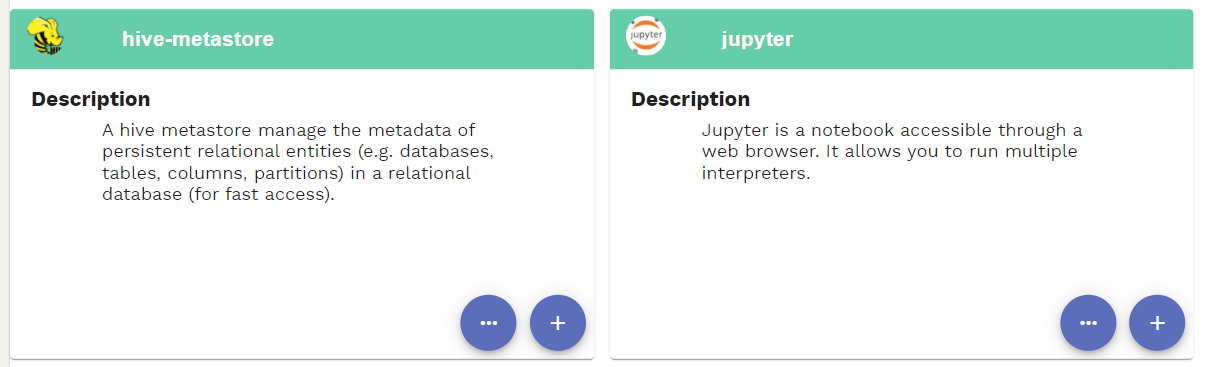

Le catalogue de services vous permet de démarrer un metastore hive. 

Nous avons fait pas mal de déclaration de table comme ceci dans le tutorial précedent précédente

```parquetDf = sqlContext.read.parquet("s3a://projet-spark-lab/diffusion/formation/data/sirene.parquet")
 parquetDf.createOrReplaceTempView("sireneparquet")```
 
 L'inconvénient majeur de cette technique est que nous n'enregistrons aucune métadonnée liée à l'existence d'une table sireneparquet.
 Ces métadonnées permettraient que de multiples clients (python , r , différents utilisateurs ou outils de visualisation) puissent tous savoir de quoi il retourne quand on cherche à accèder à la table sireneparquet.
 
L'objectif du hive metastore est exactement de faire cela : enregistrer les metadonnées de nos tables présentes sur différents lieux de stockage.

### Pré-requis

In [3]:
! cat /opt/hive/conf/hive-site.xml

<?xml version="1.0"?>
<?xml-stylesheet type="text/xsl" href="configuration.xsl"?> 
<configuration>      

<property>
    <name>hive.metastore.uris</name>
    <value>thrift://hive-metastore-1617799882:9083</value>
</property>
</configuration>


Vous devriez avoir une propriété comme cela dans votre environnement.
```<property>
    <name>hive.metastore.uris</name>
    <value>thrift://hive-metastore-1617799882:9083</value>
</property>```

Si ce n'est pas le cas, démarrez le service hive-metastore et relancer ce tutorial depuis l'interface des formations d'onyxia.

### C'est parti, créons une configuration spark

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import os

import s3fs
endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})

#fs.touch('s3://tm8enk/spark-history/.keep')

conf = SparkConf()

#url par défaut d'une api kubernetes accédé depuis l'intérieur du cluster (ici le notebook tourne lui même dans kubernetes)
conf.setMaster("k8s://https://kubernetes.default.svc:443")

#image des executors spark: pour des raisons de simplicité on réutilise l'image du notebook
conf.set("spark.kubernetes.container.image", "inseefrlab/jupyter-datascience:master")

# Nom du compte de service pour contacter l'api kubernetes : attention le package du datalab crée lui même cette variable d'enviromment.
# Dans un pod du cluster kubernetes il faut lire le fichier /var/run/secrets/kubernetes.io/serviceaccount/token
# Néanmoins ce paramètre est inutile car le contexte kubernetes local de ce notebook est préconfiguré
# conf.set("spark.kubernetes.authenticate.driver.serviceAccountName", os.environ['KUBERNETES_SERVICE_ACCOUNT']) 

# Nom du namespace kubernetes
conf.set("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])

# Nombre d'executeur spark, il se lancera autant de pods kubernetes que le nombre indiqué.
conf.set("spark.executor.instances", "5")

# Mémoire alloué à la JVM
# Attention par défaut le pod kubernetes aura une limite supérieur qui dépend d'autres paramètres.
# On manipulera plus bas pour vérifier la limite de mémoire totale d'un executeur
conf.set("spark.executor.memory", "4g")

conf.set("spark.kubernetes.driver.pod.name", os.environ['KUBERNETES_POD_NAME'])

# Paramètres d'enregistrement des logs spark d'application
# Attention ce paramètres nécessitent la création d'un dossier spark-history. Spark ne le fait pas lui même pour des raisons obscurs
# import s3fs
# endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
# fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})
# fs.touch('s3://tm8enk/spark-history/.keep')
# sparkconf.set("spark.eventLog.enabled","true")
# sparkconf.set("spark.eventLog.dir","s3a://tm8enk/spark-history")





### spark session et non spark contexte

In [2]:
# On réutilise l'objet conf des autres tutoriels mais on lance la session spark avec le builder de sparksession pour activer le support de Hive
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("5-Hive-metastore").config(conf = conf).enableHiveSupport().getOrCreate()

A partir de maintenant on va pouvoir perenniser les metadonnées de nos tables dans le metastore Hive.
Deux grandes catégories de tables :
* les tables managées (internes)
* les tables externes

Les données des tables managées sont gérés par hive qui va être en quelquesorte tout puissant sur le stockage physique et lorsque vous supprimez une table managée la donnée est supprimée du warehouse directory. Par défaut le warehouse directory "s3/idep/hive-warehouse"

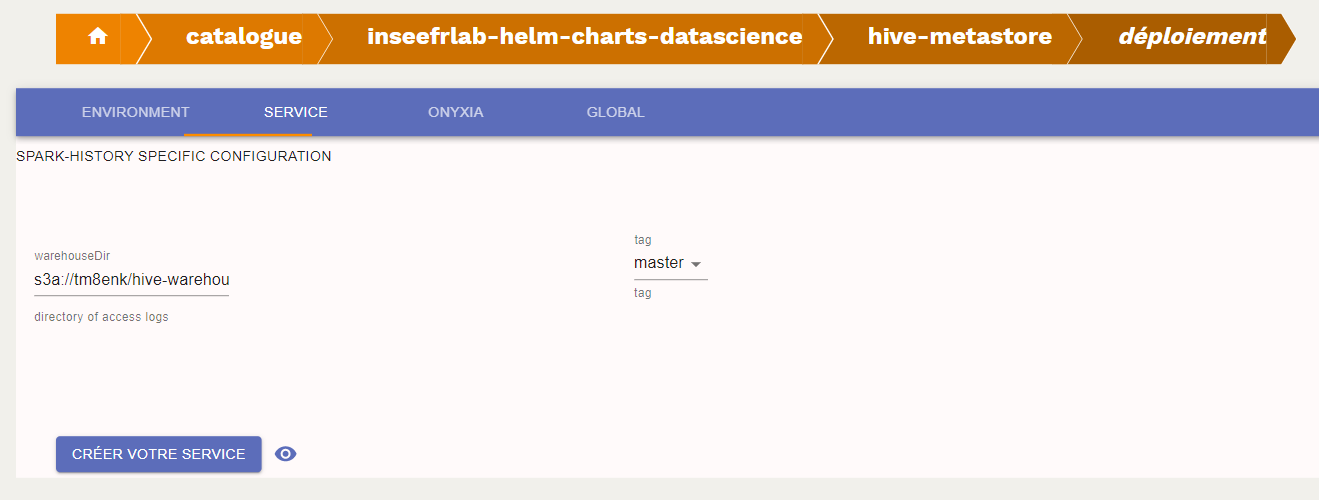

Les tables externes pointent vers des données non controlées par hive, comme des fichiers csv, json, parquet que vous auriez déjà stockés dans votre datalake.

Bref je vais essayer d'enregistrer ma table externe sirene déjà présentes sur le datalake dans le hive metastore

In [7]:
spark.sql('show tables;').show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
+--------+---------+-----------+



je n'ai enregistré aucune table encore

In [8]:
spark.sql('show databases;').show()

+---------+
|namespace|
+---------+
|  default|
+---------+



Il y a une notion de databases également que l'on peut ignorer dans ce tutorial

### Création de la table hive

Notre objectif est donc de déclarer une table sirene qui pointe vers une données présente dans notre datalake.
Cette déclaration de table hive non managées (externe) passe par les deux mots clés (external et location)
La syntaxe pour notre table est sirene 


```CREATE EXTERNAL TABLE sirene (siren int,nic int,siret bigint,dateFin string,dateDebut string,etatAdministratifEtablissement string,changementEtatAdministratifEtablissement boolean,enseigne1Etablissement string,enseigne2Etablissement string,enseigne3Etablissement string,changementEnseigneEtablissement boolean,denominationUsuelleEtablissement string,changementDenominationUsuelleEtablissement boolean,activitePrincipaleEtablissement string,nomenclatureActivitePrincipaleEtablissement string,changementActivitePrincipaleEtablissement string,caractereEmployeurEtablissement string,changementCaractereEmployeurEtablissement string ) STORED as parquet LOCATION 's3a://projet-spark-lab/diffusion/formation/data/sirene-10-partitions.parquet```

Pour réaliser ce create table on peut scripter la génération de la requête à partir du schéma des sources que le format parquet propose directement.

In [3]:
   
from pyspark import SQLContext
sqlContext=SQLContext(spark)
df = sqlContext.read.parquet("s3a://projet-spark-lab/diffusion/formation/data/sirene.parquet")
df.printSchema()
cols = df.dtypes
buf = []
buf.append('CREATE EXTERNAL TABLE sirene (')
keyanddatatypes =  df.dtypes
sizeof = len(df.dtypes)
count=1;
for eachvalue in keyanddatatypes:
    if count == sizeof:
        total = str(eachvalue[0])+str(' ')+str(eachvalue[1])
    else:
        total = str(eachvalue[0]) + str(' ') + str(eachvalue[1]) + str(',')
    buf.append(total)
    count = count + 1

buf.append(' )')
buf.append(' STORED as parquet ')
buf.append("LOCATION ")
buf.append("'")
buf.append('s3a://projet-spark-lab/diffusion/formation/data/sirene-10-partitions.parquet')
buf.append("'")

##partition by pt
tabledef = ''.join(buf)

print ("---------print definition ---------")
print (tabledef)

root
 |-- siren: integer (nullable = true)
 |-- nic: integer (nullable = true)
 |-- siret: long (nullable = true)
 |-- dateFin: string (nullable = true)
 |-- dateDebut: string (nullable = true)
 |-- etatAdministratifEtablissement: string (nullable = true)
 |-- changementEtatAdministratifEtablissement: boolean (nullable = true)
 |-- enseigne1Etablissement: string (nullable = true)
 |-- enseigne2Etablissement: string (nullable = true)
 |-- enseigne3Etablissement: string (nullable = true)
 |-- changementEnseigneEtablissement: boolean (nullable = true)
 |-- denominationUsuelleEtablissement: string (nullable = true)
 |-- changementDenominationUsuelleEtablissement: boolean (nullable = true)
 |-- activitePrincipaleEtablissement: string (nullable = true)
 |-- nomenclatureActivitePrincipaleEtablissement: string (nullable = true)
 |-- changementActivitePrincipaleEtablissement: string (nullable = true)
 |-- caractereEmployeurEtablissement: string (nullable = true)
 |-- changementCaractereEmployeu

In [12]:
spark.sql(tabledef);

In [3]:
spark.sql('show tables;').show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default|   sirene|      false|
+--------+---------+-----------+



In [4]:
%time spark.sql('SELECT count(*) as tot , activitePrincipaleEtablissement FROM sirene group by activitePrincipaleEtablissement order by tot desc LIMIT 10').show()

+--------+-------------------------------+
|     tot|activitePrincipaleEtablissement|
+--------+-------------------------------+
|11036361|                           null|
| 2822417|                         68.20B|
| 1724189|                          70.2C|
|  961082|                         70.22Z|
|  918291|                         68.20A|
|  760587|                         94.99Z|
|  730658|                         70.10Z|
|  727597|                          74.1J|
|  686920|                          85.1G|
|  650500|                          70.2A|
+--------+-------------------------------+

CPU times: user 3.74 ms, sys: 5.13 ms, total: 8.87 ms
Wall time: 24.8 s


In [7]:
spark.stop()

### Un metastore persistant

L'objectif de cette partie est de vous expliquer techniquement les services que vous lancez en cliquant sur la carte hive-metastore.

In [8]:
!kubectl get pods

NAME                                         READY   STATUS    RESTARTS   AGE
hive-metastore-1617870268-5c788d6bcd-nfpk8   1/1     Running   0          4h21m
hive-metastore-db-0                          1/1     Running   0          4h20m
jupyter-1617870316-df977df88-kc7hr           1/1     Running   0          4h20m
vscode-1617202459-79f7f9b84f-6xtlv           1/1     Running   2          7d21h
vscode-1617713509-7d844d868f-xkpqs           1/1     Running   2          47h


Le metastore se compose d'un service hive-metastore et d'une base de donnée postgres associé à ce metastore.
Les données du metastore se trouve dans un volume persistant dynamique.. (pvc)

In [11]:
!kubectl get pvc --field-selector metadata.name=data-hive-metastore-db-0

NAME                       STATUS   VOLUME                                     CAPACITY   ACCESS MODES   STORAGECLASS      AGE
data-hive-metastore-db-0   Bound    pvc-a049976a-684d-4e06-9bf0-8a85b76aa172   8Gi        RWO            rook-ceph-block   2d15h


Si vous supprimez la carte du metastore sur Onyxia, le pvc associé ne sera pas supprimé et au prochain lancement du metastore le pvc sera réutilisé par le service postgres. Vous pouvez donc supprimer ce service sans craindre de perdre vos métadonnées. A l'inverse si vous voulez repartir de 0, il faut supprimer la carte et executer 

In [12]:
# kubectl delete pvc data-hive-metastore-db-0

Le nom du pvc est unique ce qui permet de recuperer facilement les données à chaque démarrage, à l'inverse vous ne pouvez lancer qu'un seul hive-metastore dans votre namespace.

## Conclusion

Nous sommes en mesure d'enregistrer les métadonnées de nos tables présentes sur le datalake pour les réutiliser ultérieurement ou simplement pour s'y connecter depuis des clients différents. Le tutorial suivant consistera à vous montrer un autre service du datalab qui peut en profiter le ***spark thrift server***

In [ ]:
spark.stop()